In [3]:
import paddle
from paddle.vision.transforms import Normalize

transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 加载 MNIST 训练集和测试集
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

# 模型组网，构建并初始化一个模型 mnist
mnist = paddle.nn.Sequential(
    paddle.nn.Flatten(1, -1),
    paddle.nn.Linear(784, 512),
    paddle.nn.ReLU(),
    paddle.nn.Dropout(0.2),
    paddle.nn.Linear(512, 10)
)


In [10]:
class MyDataset(paddle.io.Dataset):
    def __init__(self,dataset):
        super(MyDataset,self).__init__()
        self.dataset=dataset
    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)//5

self_train_dataset=MyDataset(train_dataset)
self_test_dataset=MyDataset(test_dataset)



In [8]:
# 封装模型为一个 model 实例，便于进行后续的训练、评估和推理
model = paddle.Model(mnist)
# 为模型训练做准备，设置优化器及其学习率，并将网络的参数传入优化器，设置损失函数和精度计算方式
model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()),
              loss=paddle.nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())


In [11]:
# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(self_train_dataset,eval_data=self_test_dataset,
          epochs=5,
          batch_size=64,
          verbose=1)


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/5
step 188/188 [==============================] - loss: 0.3066 - acc: 0.8209 - 10ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 32/32 [==============================] - loss: 0.2979 - acc: 0.8610 - 8ms/step          
Eval samples: 2000
Epoch 2/5
step 188/188 [==============================] - loss: 0.2239 - acc: 0.9100 - 9ms/step           
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 32/32 [==============================] - loss: 0.2277 - acc: 0.9005 - 7ms/step          
Eval samples: 2000
Epoch 3/5
step 188/188 [==============================] - loss: 0.1078 - acc: 0.9326 - 7ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the avera

In [12]:
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(self_test_dataset, verbose=1)
print(eval_result)


Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 10000/10000 [==============================] - loss: 6.6757e-06 - acc: 0.9398 - 3ms/step          
Eval samples: 10000
{'loss': [6.675698e-06], 'acc': 0.9398}


# predict输出
模型是单一输出：结果为[1,n批，m种类数],[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n)]，
模型是多输出：结果为[m,n],[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), (numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), …]

如果模型是单一输出，则输出的形状为 [1, n]，n 表示数据集的样本数。其中每个 numpy_ndarray_n 是对应原始数据经过模型计算后得到的预测结果，类型为 numpy 数组，例如 mnist 分类任务中，每个 numpy_ndarray_n 是长度为 10 的 numpy 数组。

如果模型是多输出，则输出的形状为[m, n]，m 表示标签的种类数，在多标签分类任务中，m 会根据标签的数目而定。

In [22]:
test_result=model.predict(self_test_dataset)
print(len(test_result)) #1
print(len(test_result[0]))#2000
print(test_result[0][0])

Predict begin...
step 2000/2000 [==============================] - 3ms/step          
Predict samples: 2000
1
2000
[[-2.6724722 -3.3764327  1.6130106  4.3637486 -6.9111414 -0.8649532
  -8.738144  10.380799  -0.8362608  1.0366589]]


In [49]:
pred_label=test_result[0][20].argmax()
img,true_label=self_test_dataset[20]
print(f'pred_label:{pred_label} true_label：{true_label}')

pred_label:9 true_label：[9]


(1, 28, 28)


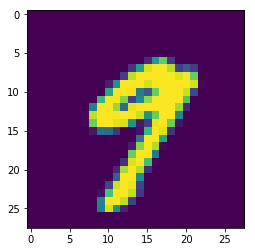

In [50]:
print(img.shape)
from matplotlib import pyplot as plt
plt.imshow(img[0])

# fit拆解
飞桨框架通过基础 API 对模型进行训练，对应高层 API 的 Model.prepare 与 Model.fit ，一般包括如下几个步骤：

加载训练数据集、声明模型、设置模型实例为 train 模式

设置优化器、损失函数与各个超参数

设置模型训练的二层循环嵌套，并在内层循环嵌套中设置如下内容

3.1 从数据读取器 DataLoader 获取一批次训练数据

3.2 执行一次预测，即经过模型计算获得输入数据的预测值

3.3 计算预测值与数据集标签的损失

3.4 计算预测值与数据集标签的准确率

3.5 将损失进行反向传播

3.6 打印模型的轮数、批次、损失值、准确率等信息

3.7 执行一次优化器步骤，即按照选择的优化算法，根据当前批次数据的梯度更新传入优化器的参数

3.8 将优化器的梯度进行清零

In [29]:

# dataset与mnist的定义与使用高层API的内容一致
# 用 DataLoader 实现数据加载
train_loader = paddle.io.DataLoader(self_train_dataset,batch_size=64, shuffle=True)

# 将mnist模型及其所有子层设置为训练模式。这只会影响某些模块，如Dropout和BatchNorm。
mnist.train()

# 设置迭代次数
epochs = 5

# 设置优化器
optim = paddle.optimizer.Adam(parameters=mnist.parameters())
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):

        x_data = data[0]            # 训练数据
        y_data = data[1]            # 训练数据标签
        predicts = mnist(x_data)    # 预测结果

        # 计算损失 等价于 prepare 中loss的设置
        loss = loss_fn(predicts, y_data)

        # 计算准确率 等价于 prepare 中metrics的设置
        acc = paddle.metric.accuracy(predicts, y_data)

        # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中
        # 反向传播
        loss.backward()

        if (batch_id+1) % 50 == 0:
            print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id+1, loss.numpy(), acc.numpy()))
        # 更新参数
        optim.step()
        # 梯度清零
        optim.clear_grad()

epoch: 0, batch_id: 50, loss is: [0.00323081], acc is: [1.]
epoch: 0, batch_id: 100, loss is: [0.00069481], acc is: [1.]
epoch: 0, batch_id: 150, loss is: [0.05160624], acc is: [0.984375]
epoch: 1, batch_id: 50, loss is: [0.00458183], acc is: [1.]
epoch: 1, batch_id: 100, loss is: [0.04618767], acc is: [0.96875]
epoch: 1, batch_id: 150, loss is: [0.00937446], acc is: [1.]
epoch: 2, batch_id: 50, loss is: [0.15390609], acc is: [0.96875]
epoch: 2, batch_id: 100, loss is: [0.04789619], acc is: [0.984375]
epoch: 2, batch_id: 150, loss is: [0.00231787], acc is: [1.]
epoch: 3, batch_id: 50, loss is: [0.00377524], acc is: [1.]
epoch: 3, batch_id: 100, loss is: [0.00986299], acc is: [1.]
epoch: 3, batch_id: 150, loss is: [0.0172553], acc is: [1.]
epoch: 4, batch_id: 50, loss is: [0.0087923], acc is: [1.]
epoch: 4, batch_id: 100, loss is: [0.01462703], acc is: [1.]
epoch: 4, batch_id: 150, loss is: [0.07881232], acc is: [0.984375]


# Model.evaluate拆解
飞桨框架通过基础 API 对训练好的模型进行评估，对应高层 API 的 `Model.evaluate` 。与模型训练相比，模型评估的流程有如下几点不同之处：

1. 加载的数据从训练数据集改为测试数据集

2. 模型实例从 `train` 模式改为 `eval` 模式

3. 不需要反向传播、优化器参数更新和优化器梯度清零

In [ ]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
# 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
mnist.eval()
# 禁用动态图梯度计算
for batch_id, data in enumerate(test_loader()):

    x_data = data[0]            # 测试数据
    y_data = data[1]            # 测试数据标签
    predicts = mnist(x_data)    # 预测结果

    # 计算损失与精度
    loss = loss_fn(predicts, y_data)
    acc = paddle.metric.accuracy(predicts, y_data)

    # 打印信息
    if (batch_id+1) % 30 == 0:
        print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id+1, loss.numpy(), acc.numpy()))


### 模型推理（拆解 Model.predict）[¶](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/beginner/train_eval_predict_cn.html#id2 "永久链接至标题")

飞桨框架通过基础 API 对训练好的模型执行推理，对应高层 API 的 `Model.predict` 。模型的推理过程相对独立，是在模型训练与评估之后单独进行的步骤。只需要执行如下步骤：

1. 加载待执行推理的测试数据，并将模型设置为 `eval` 模式

2. 读取测试数据并获得预测结果

3. 对预测结果进行后处理

In [ ]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 将该模型及其所有子层设置为预测模式
mnist.eval()
for batch_id, data in enumerate(test_loader()):
    # 取出测试数据
    x_data = data[0]
    # 获取预测结果
    predicts = mnist(x_data)
print("predict finished")

In [71]:
test_loader = paddle.io.DataLoader(self_test_dataset, batch_size=64, drop_last=True)
# 从测试集中取出一组数据，一批数据
img, label = self_test_dataset[30]
img=paddle.to_tensor(img) #test_loader会自动转换为tensor，所dataset不能
# 执行推理并打印结果，第一个的预测结果
pred_label = mnist(img)[0].argmax()
print('true label: {}, pred label: {}'.format(label, pred_label.numpy().item()))



true label: [3], pred label: 3


(1, 28, 28)


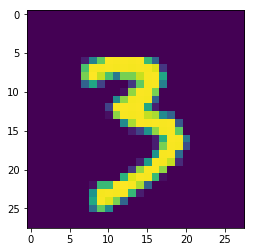

In [72]:
img=self_test_dataset[30]
print(img[0].shape)
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0][0])

# 总结
本节中介绍了在飞桨框架中使用高层 API 进行模型训练、评估和推理的方法，并拆解出对应的基础 API 实现方法。需要注意的是，这里的推理仅用于模型效果验证，实际生产应用中，则可使用飞桨提供的一系列推理部署工具，满足服务器端、移动端、网页/小程序等多种环境的模型部署上线需求，具体可参见 推理部署 章节。

同时，飞桨的高层 API 和基础 API 可以组合使用，并不是完全割裂开的，这样有助于开发者更便捷地完成算法迭代。示例代码如下：

In [46]:
from  paddle.vision.models import LeNet

class FaceNet(paddle.nn.Layer):
    def __init__(self):
        super().__init__()
        # 使用高层API组网
        self.backbone = LeNet()
        # 使用基础API组网
        self.outLayer1 = paddle.nn.Sequential(
            paddle.nn.Linear(10, 512),
            paddle.nn.ReLU(),
            paddle.nn.Dropout(0.2)
        )
        self.outLayer2 = paddle.nn.Linear(512, 10)

    def forward(self, inputs):
        out = self.backbone(inputs)
        out = self.outLayer1(out)
        out = self.outLayer2(out)
        return out
# 使用高层API封装网络
model = paddle.Model(FaceNet())
# 使用基础API定义优化器
optim = paddle.optimizer.Adam(learning_rate=1e-3, parameters=model.parameters())
# 使用高层API封装优化器和损失函数
model.prepare(optim, paddle.nn.CrossEntropyLoss(), metrics=paddle.metric.Accuracy())
# 使用高层API训练网络
model.fit(train_dataset, test_dataset, epochs=5, batch_size=64, verbose=1)


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/5
step 938/938 [==============================] - loss: 0.0308 - acc: 0.9250 - 11ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 0.0029 - acc: 0.9727 - 8ms/step          
Eval samples: 10000
Epoch 2/5
step 938/938 [==============================] - loss: 0.0142 - acc: 0.9732 - 11ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 0.0011 - acc: 0.9801 - 9ms/step          
Eval samples: 10000
Epoch 3/5
step 938/938 [==============================] - loss: 0.0070 - acc: 0.9792 - 11ms/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is th